# Single Model Uses

This notebook shows some uses of the forced baroptric model with singel model runs. See model_ensemble for uses as it pertains to ensembles of runs

In [1]:
# This directive tells the notebook to add interactive plots in the notebook
#%matplotlib widget
import sys
sys.path.append('../src')  # Add the 'src' directory to the Python path
from model.solver import Solver #bm3_barotropic_model packages
from model.sphere import Sphere
from utils import constants, plotting

import time
import numpy as np
import random
import xarray as xr

import cartopy as crt             # Map projection stuff
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib as mpl          # Plotting routines
import matplotlib.pyplot as plt    
import matplotlib.animation as manim
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm

from IPython.display import display, clear_output, HTML, FileLink  # Some technical stuff, used to display animation

/home/bertossa/miniconda3/envs/jupyter/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We may simply integrate a single model and plot the resulting output at the final integration step

In [2]:
#dt = 1000 #time between integration steps (seconds)
#Nt = 1000 #number of integration steps
T= constants.day2sec*5 #total integration time
#print('integrating for {:.1f} days with a dt of {:.2f} hours'.format(T*s2d,dt*s2h))

st = Sphere()

#Si = F.generate_rededdy_start() #initial forcing
#forcing_tseries = F.generate_rededdy_tseries(A=1e-11,Si=Si) #evolve forcing
#forcing_tseries = F.generate_zeroforcing_tseries()

k0=3 #if we want to start with some structure in the vorticity here's an option
vortp = 1e-5 * np.exp( -0.5 * (st.glats - 45.)**2 / 10**2 ) * np.cos(k0 * st.rlons)

Pvortp = 1e-5 * np.exp( -0.5 * (st.glats - 45.)**2 / 10**2 -0.5 * (st.glons - 60.)**2 / 10**2 )

#vortp = np.zeros(thetap.shape)
thetap = np.zeros(vortp.shape) #we'll start with t0=background state
st.set_ics([vortp,thetap])

params=dict(nu=0., tau = 1/8, diffusion_order=3, forcing_type='rededdy')

# Turn off frictional dissipation, thermal relaxation, add viscosity values from Held 1985
#params = dict(rs = 0., tau = 0., nu = 1e4, diffusion_order=1, robert_filter=0.01)

# Turn off frictional dissipation, add viscosity values from Held and Phillips 1987
#params = dict(rs = 0., nu = 1e15, diffusion_order=2)

#choose whether we integrate with a linear temp/vorticity field. temp_linear=False uses nonlinear advection
S = Solver(st, T= T, **params)

sln = S.integrate_dynamics(verbose=True)

100%|████████████████████████████████████████| 240/240 [00:01<00:00, 221.91it/s]


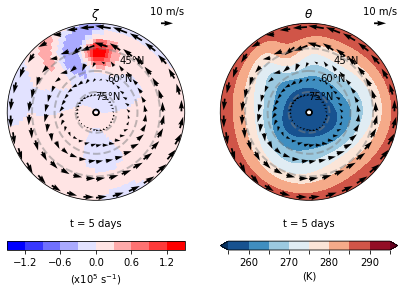

In [3]:
tidx=-1
#tidx=int(Nt/ofreq)-1
f,ax = plotting.plot_overview(sln.isel(time=tidx), levels=[np.linspace(-1.5,1.5,11),np.arange(255,300,5)], var=['vort','theta'])
#f.savefig('./images/L18_singlerun.png',dpi=300, bbox_inches='tight')

array([<AxesSubplot:title={'center':'Perturbation Energy'}, xlabel='time (days)'>,
       <AxesSubplot:title={'center':'Perturbation Enstrophy'}, xlabel='time (days)'>],
      dtype=object)

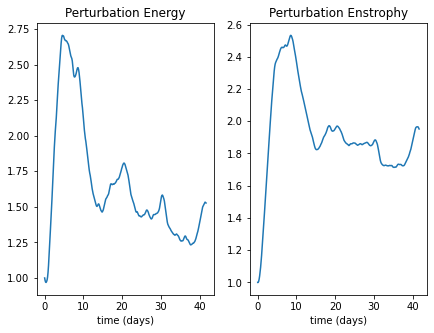

In [9]:
from importlib import reload
reload(plotters)
plotters.plot_energy(sln)


In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

MovieWriter ffmpeg unavailable; using Pillow instead.


time taken to animate:  538.696888923645


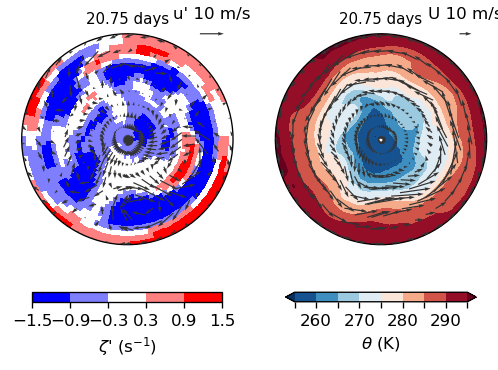

In [13]:
#careful..this takes quite a while to run. ~4s/frame
starttime = time.time()
plotters.overview_animation(sln, times = [0,T], xs=None, filename = './images/overview_nonlinear_dt3000.gif')
print('time taken to animate: ', time.time()-starttime)

### Tracking parcels
We can use a parcel tracking routine to help show spread growth

In [8]:
dsr = sln.rename(dict(x='lon',y='lat'))
# Reassign longitude coordinates between -180 and 180E
dsr = dsr.assign_coords(lon=(((dsr.lon + 180) % 360) - 180))
dsr = dsr.sortby('lon')

x0 = [(-100., l) for l in np.linspace(45, 65, 10)] #initial position of parcel
t0=0. #t0=(0,T)
ts, xs = tracking.calculate_trajectories(dsr, x0, t0 = sln.time.isel(time=0).data)


Integrating 10 trajectories for [41.66666667].
  1. From -100 E, 45 N at 0.0.
  2. From -100 E, 47.2222 N at 0.0.
  3. From -100 E, 49.4444 N at 0.0.
  4. From -100 E, 51.6667 N at 0.0.
  5. From -100 E, 53.8889 N at 0.0.
  6. From -100 E, 56.1111 N at 0.0.
  7. From -100 E, 58.3333 N at 0.0.
  8. From -100 E, 60.5556 N at 0.0.
  9. From -100 E, 62.7778 N at 0.0.
  10. From -100 E, 65 N at 0.0.


 21%|████████▍                               | 351/1664 [01:27<05:27,  4.01it/s]

KeyboardInterrupt



In [ ]:
#plotters.overview_animation(sln, times = [0,T],filename = 'trajectory.gif', xs=xs,ts=ts)